<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com) for PyCon 2015. Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_pycon2015/).</i></small>

# 深入监督学习：随机森林

前面我们见过了一种强大的分类器：**支持向量机**。
这里我们将看到另外一种强大的算法，这是一种*non-parametric*算法叫做**随机森林**。

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## 随机森林：决策树

随机森林基于决策树，它是*集成学习*的一个例子。基于这个原因，我们用决策树开始介绍。
决策树用一种非常直观的方式来分类对象：你可以问一系列问题来做出yes或no的判断。

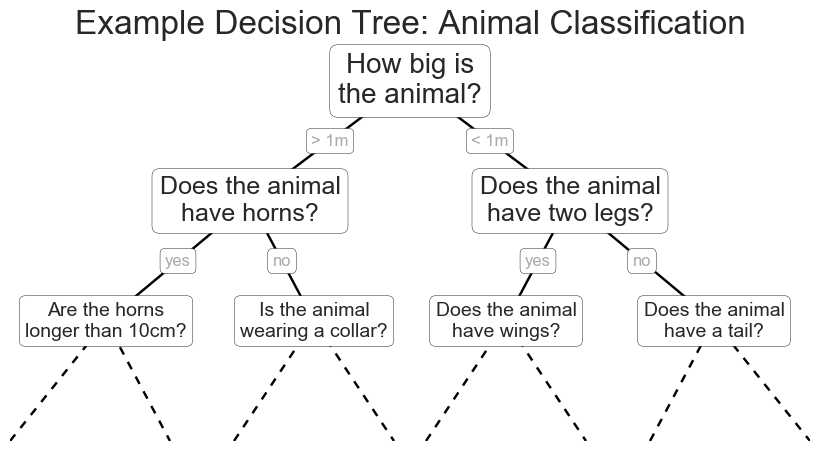

In [28]:
import fig_code
fig_code.plot_example_decision_tree()

上面的二叉树分类很有效率。这个技巧的关键是*对特征提问*。
这个过程是这样的：在训练决策树分类器过程中，算法查找每一个特征，然后决定哪一个是正确的答案。

### 创建决策树

这里是sklearn中的决策树分类器的一个例子。我们开始定义一些二维的打过标签的数据。

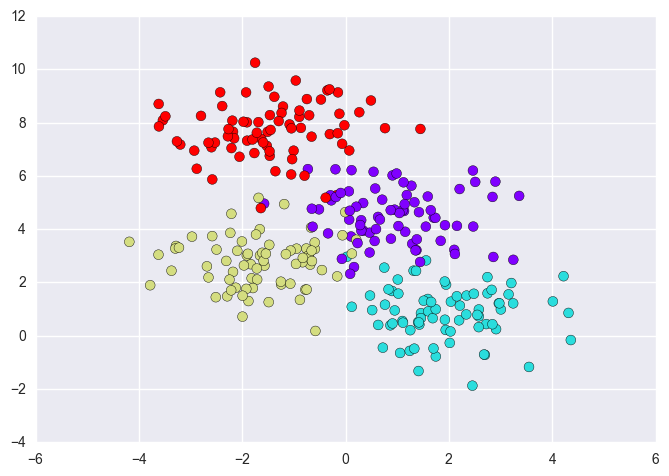

In [29]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

我们引入一些可视化的函数

In [30]:
from fig_code import visualize_tree, plot_tree_interactive

现在我们使用IPython的``interact``，来看一下决策树的分割过程：

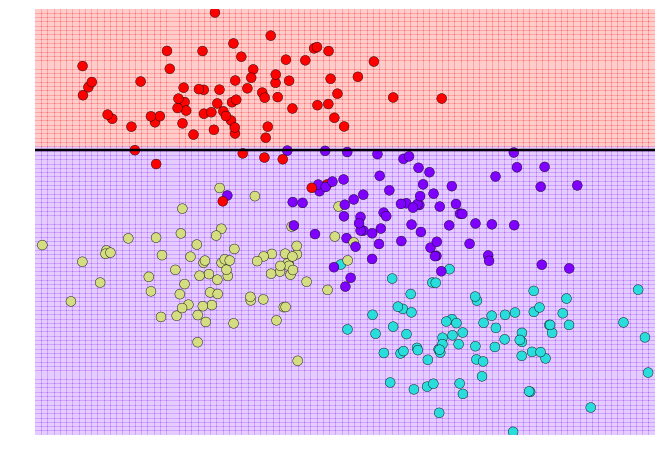

In [32]:
plot_tree_interactive(X, y);

注意随着深度的增加，这些节点一分为二，这些节点只包含一个分类。它是非常快速的**非参数**分类，在实践中很有用。

**问题：你能发现上面的有什么问题？ **

### 决策树和过拟合

决策树有个问题，就是它很容易产生过拟合。因为他们在分类的过程很容易学习到**noise**而不是**signal**。我们看下两棵决策树根据同一个数据集中两个不同子类构造的过程：

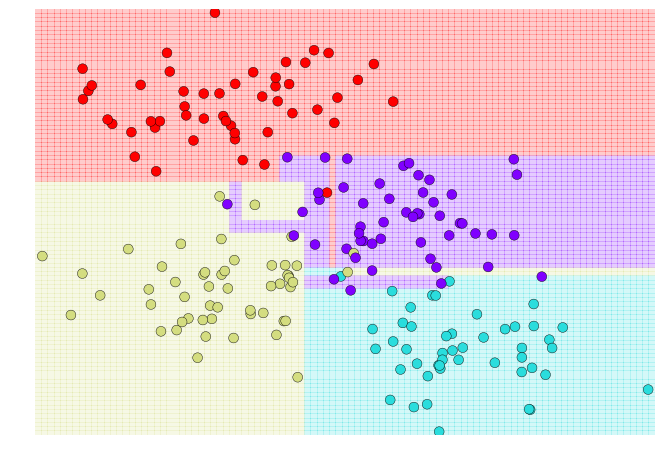

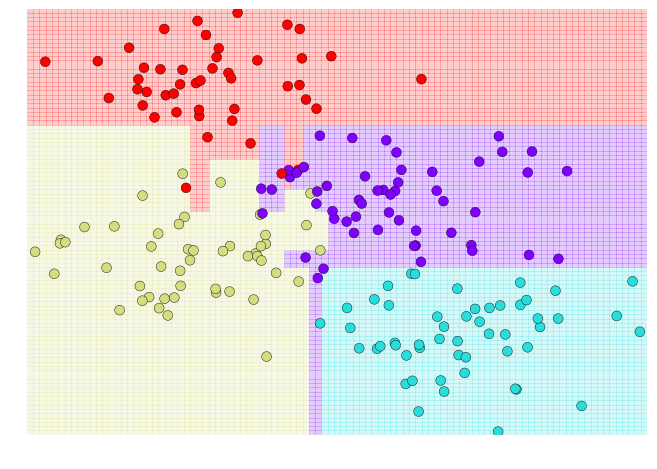

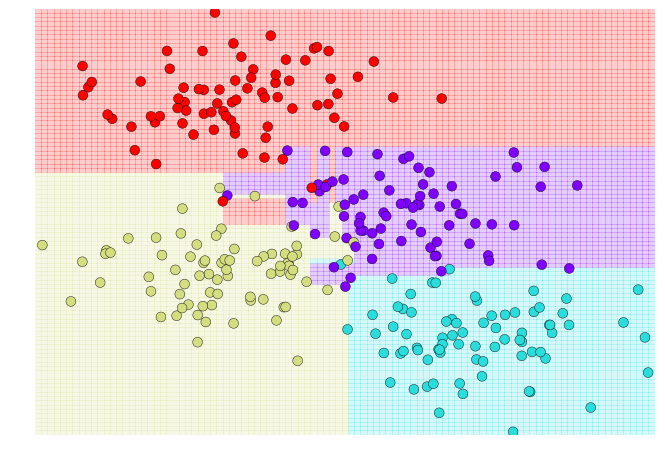

In [36]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

plt.figure()
visualize_tree(clf, X[:200], y[:200], boundaries=False)
plt.figure()
visualize_tree(clf, X[-200:], y[-200:], boundaries=False)

分类完全不同！很明显这产生了**过拟合**：当预测新的样本时，结果反映了模型中的**noise**而不是**signal**。

## Estimators的集成：随机森林

一个解决过拟合的可以方式是使用**集成方法**：这是一个*meta-estimator*，它由多个独立的estimator组成，能够平衡每个estimator过拟合结果。和它包含的单独的estimator相比，评估的结果看上去更加健壮和精确。

一个最常见的集成方法叫做**随机森林**，它由许多决策树组成。

让我先看看下面的决策树例子获得一个感性的认识：

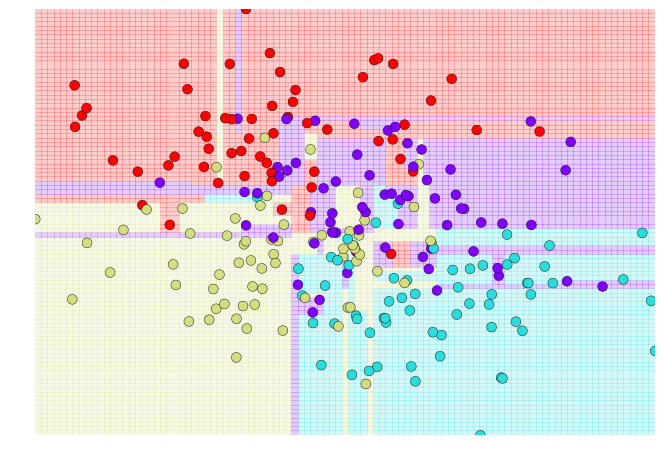

In [37]:
def fit_randomized_tree(random_state=0):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=2.0)
    clf = DecisionTreeClassifier(max_depth=15)
    
    rng = np.random.RandomState(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)
    visualize_tree(clf, X[i[:250]], y[i[:250]], boundaries=False,
                   xlim=(X[:, 0].min(), X[:, 0].max()),
                   ylim=(X[:, 1].min(), X[:, 1].max()))
    
from IPython.html.widgets import interact
interact(fit_randomized_tree, random_state=[0, 100]);

虽然样本发生变化时模型对样本的分类也变化了，但是大的特性保持不变。随机森林分类器做的事情类似，它综合考虑了所有决策树的判断：

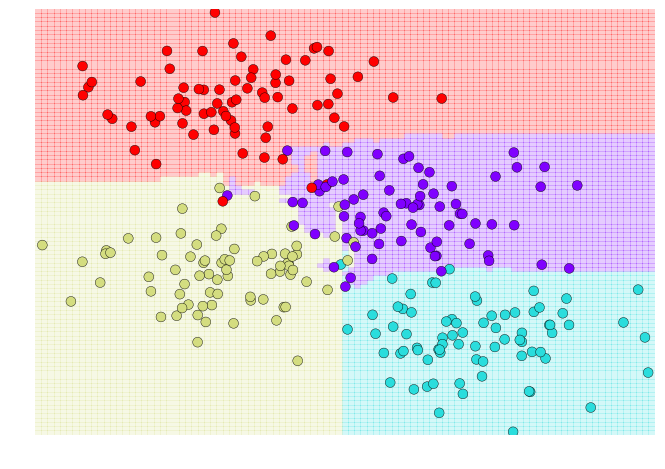

In [40]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_tree(clf, X, y, boundaries=False);

通过平衡100个随机模型，随机森林最后得出的模型更好拟合了数据。

## 例子：移步到回归

上面我们在分类问题上使用了随机森林。它在回归问题上也能很好地工作。使用的estimator叫做``sklearn.ensemble.RandomForestRegressor``。

让我们来看下怎么使用它：

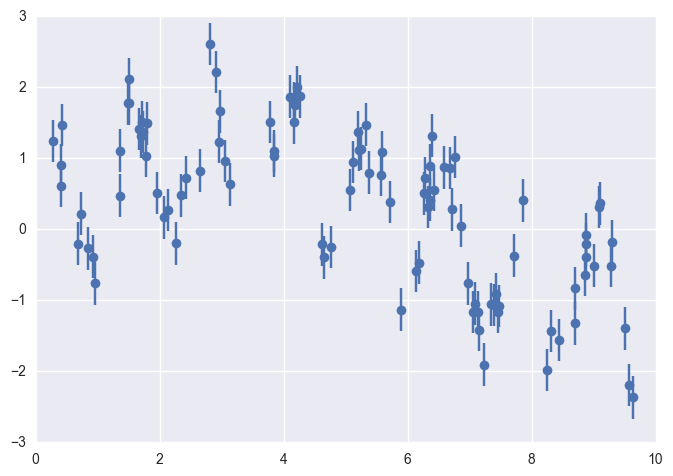

In [41]:
from sklearn.ensemble import RandomForestRegressor

x = 10 * np.random.rand(100)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * np.random.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

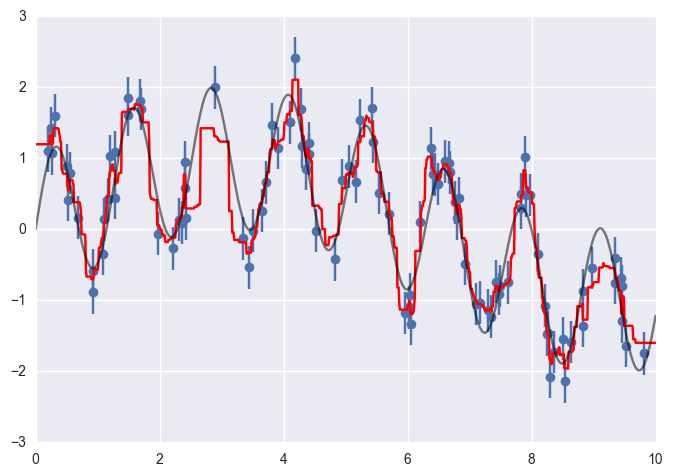

In [16]:
xfit = np.linspace(0, 10, 1000)
yfit = RandomForestRegressor(100).fit(x[:, None], y).predict(xfit[:, None])
ytrue = model(xfit, 0)

plt.errorbar(x, y, 0.3, fmt='o')
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

我们可以看到，我们甚至没有指定一个multi-period模型，随机森林就能够足够灵活地适应了multi-period数据。

## 例子：应用随机森林分类数字

我们之前见过了**手写数字**数据集。我们这里也用它来测试随机森林的准确率。

In [49]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

['images', 'data', 'target_names', 'DESCR', 'target']

In [50]:
X = digits.data
y = digits.target
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


首先我们看一下这些手写数字：

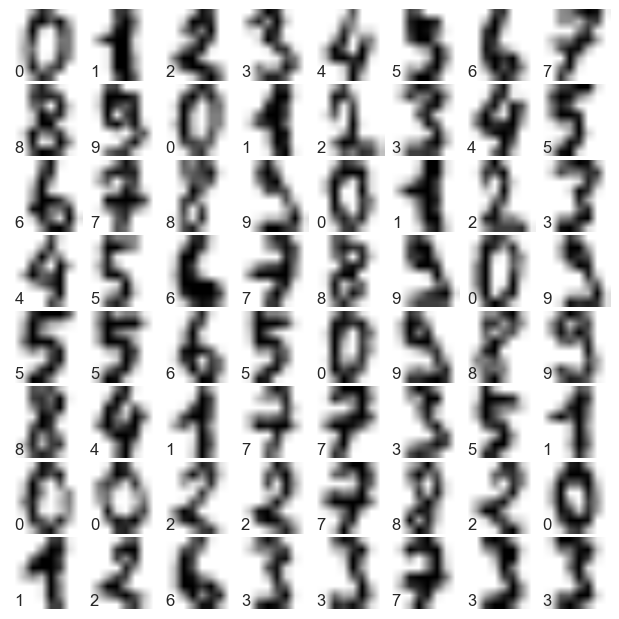

In [51]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary)
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

我们能快速使用决策树来对这些数字进行分类：

In [52]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
clf = DecisionTreeClassifier(max_depth=11)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

我们检查一下分类器准确率：

In [53]:
metrics.accuracy_score(ypred, ytest)

0.84222222222222221

用混淆矩阵更直观：

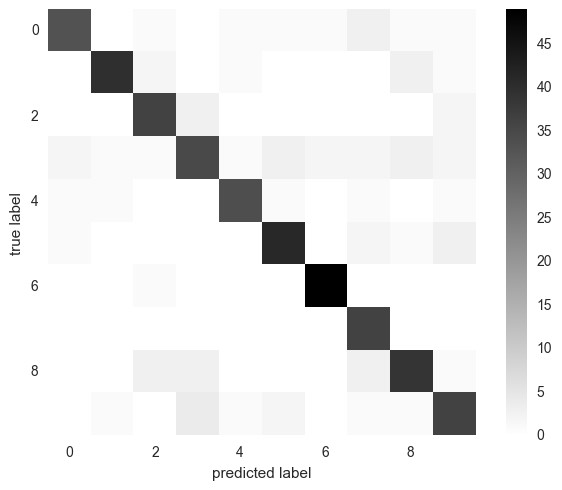

In [55]:
plt.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");

### 练习
1. 用``sklearn.ensemble.RandomForestClassifier``来实现上面的任务。调教`max_depth``，``max_features``和``n_estimators``参数
会对结果造成什么影响？
2. 再用``sklearn.svm.SVC``分类器，调节``kernel``, ``C``和``gamma``试试看？
3. 对每一个模型用一些参数集，然后检查一下F1分数（``sklearn.metrics.f1_score``）。